# Scanpy: Differential expression

Once we have done clustering, let's compute a ranking for the highly differential genes in each cluster. 


Differential expression is performed with the function `rank_genes_group`.  The default method to compute differential expression is the `t-test_overestim_var`. Other implemented methods are: `logreg`, `t-test` and `wilcoxon`.

By default, the .raw attribute of AnnData is used in case it has been initialized, it can be changed by setting `use_raw=False`. 

The clustering with resolution 0.6 seems to give a reasonable number of clusters, so we will use that clustering for all DE tests.

First, let's import libraries and fetch the clustered data from the previous lab.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy
import matplotlib.pyplot as plt

sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()


In [2]:
sc.settings.set_figure_params(dpi=80)

Read in the clustered data object.

In [45]:
adata = sc.read_h5ad('./data/results/scanpy_clustered_covid.h5ad')

In [46]:
print(adata.X.shape)
print(adata.raw.X.shape)
print(adata.raw.X[:10,:10])

(5594, 3067)
(5594, 18752)
  (0, 1)	1.0
  (0, 6)	1.0
  (1, 6)	2.0
  (2, 6)	1.0


As you can see, the X matrix only contains the variable genes, while the raw matrix contains all genes.

Printing a few of the values in `adata.raw.X` shows that the raw matrix is not normalized.

For DGE analysis we would like to run with all genes, but on normalized values, so we will have to revert back to the raw matrix and renormalize.

In [47]:
adata = adata.raw.to_adata()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### T-test 

ranking genes
    finished (0:00:00)


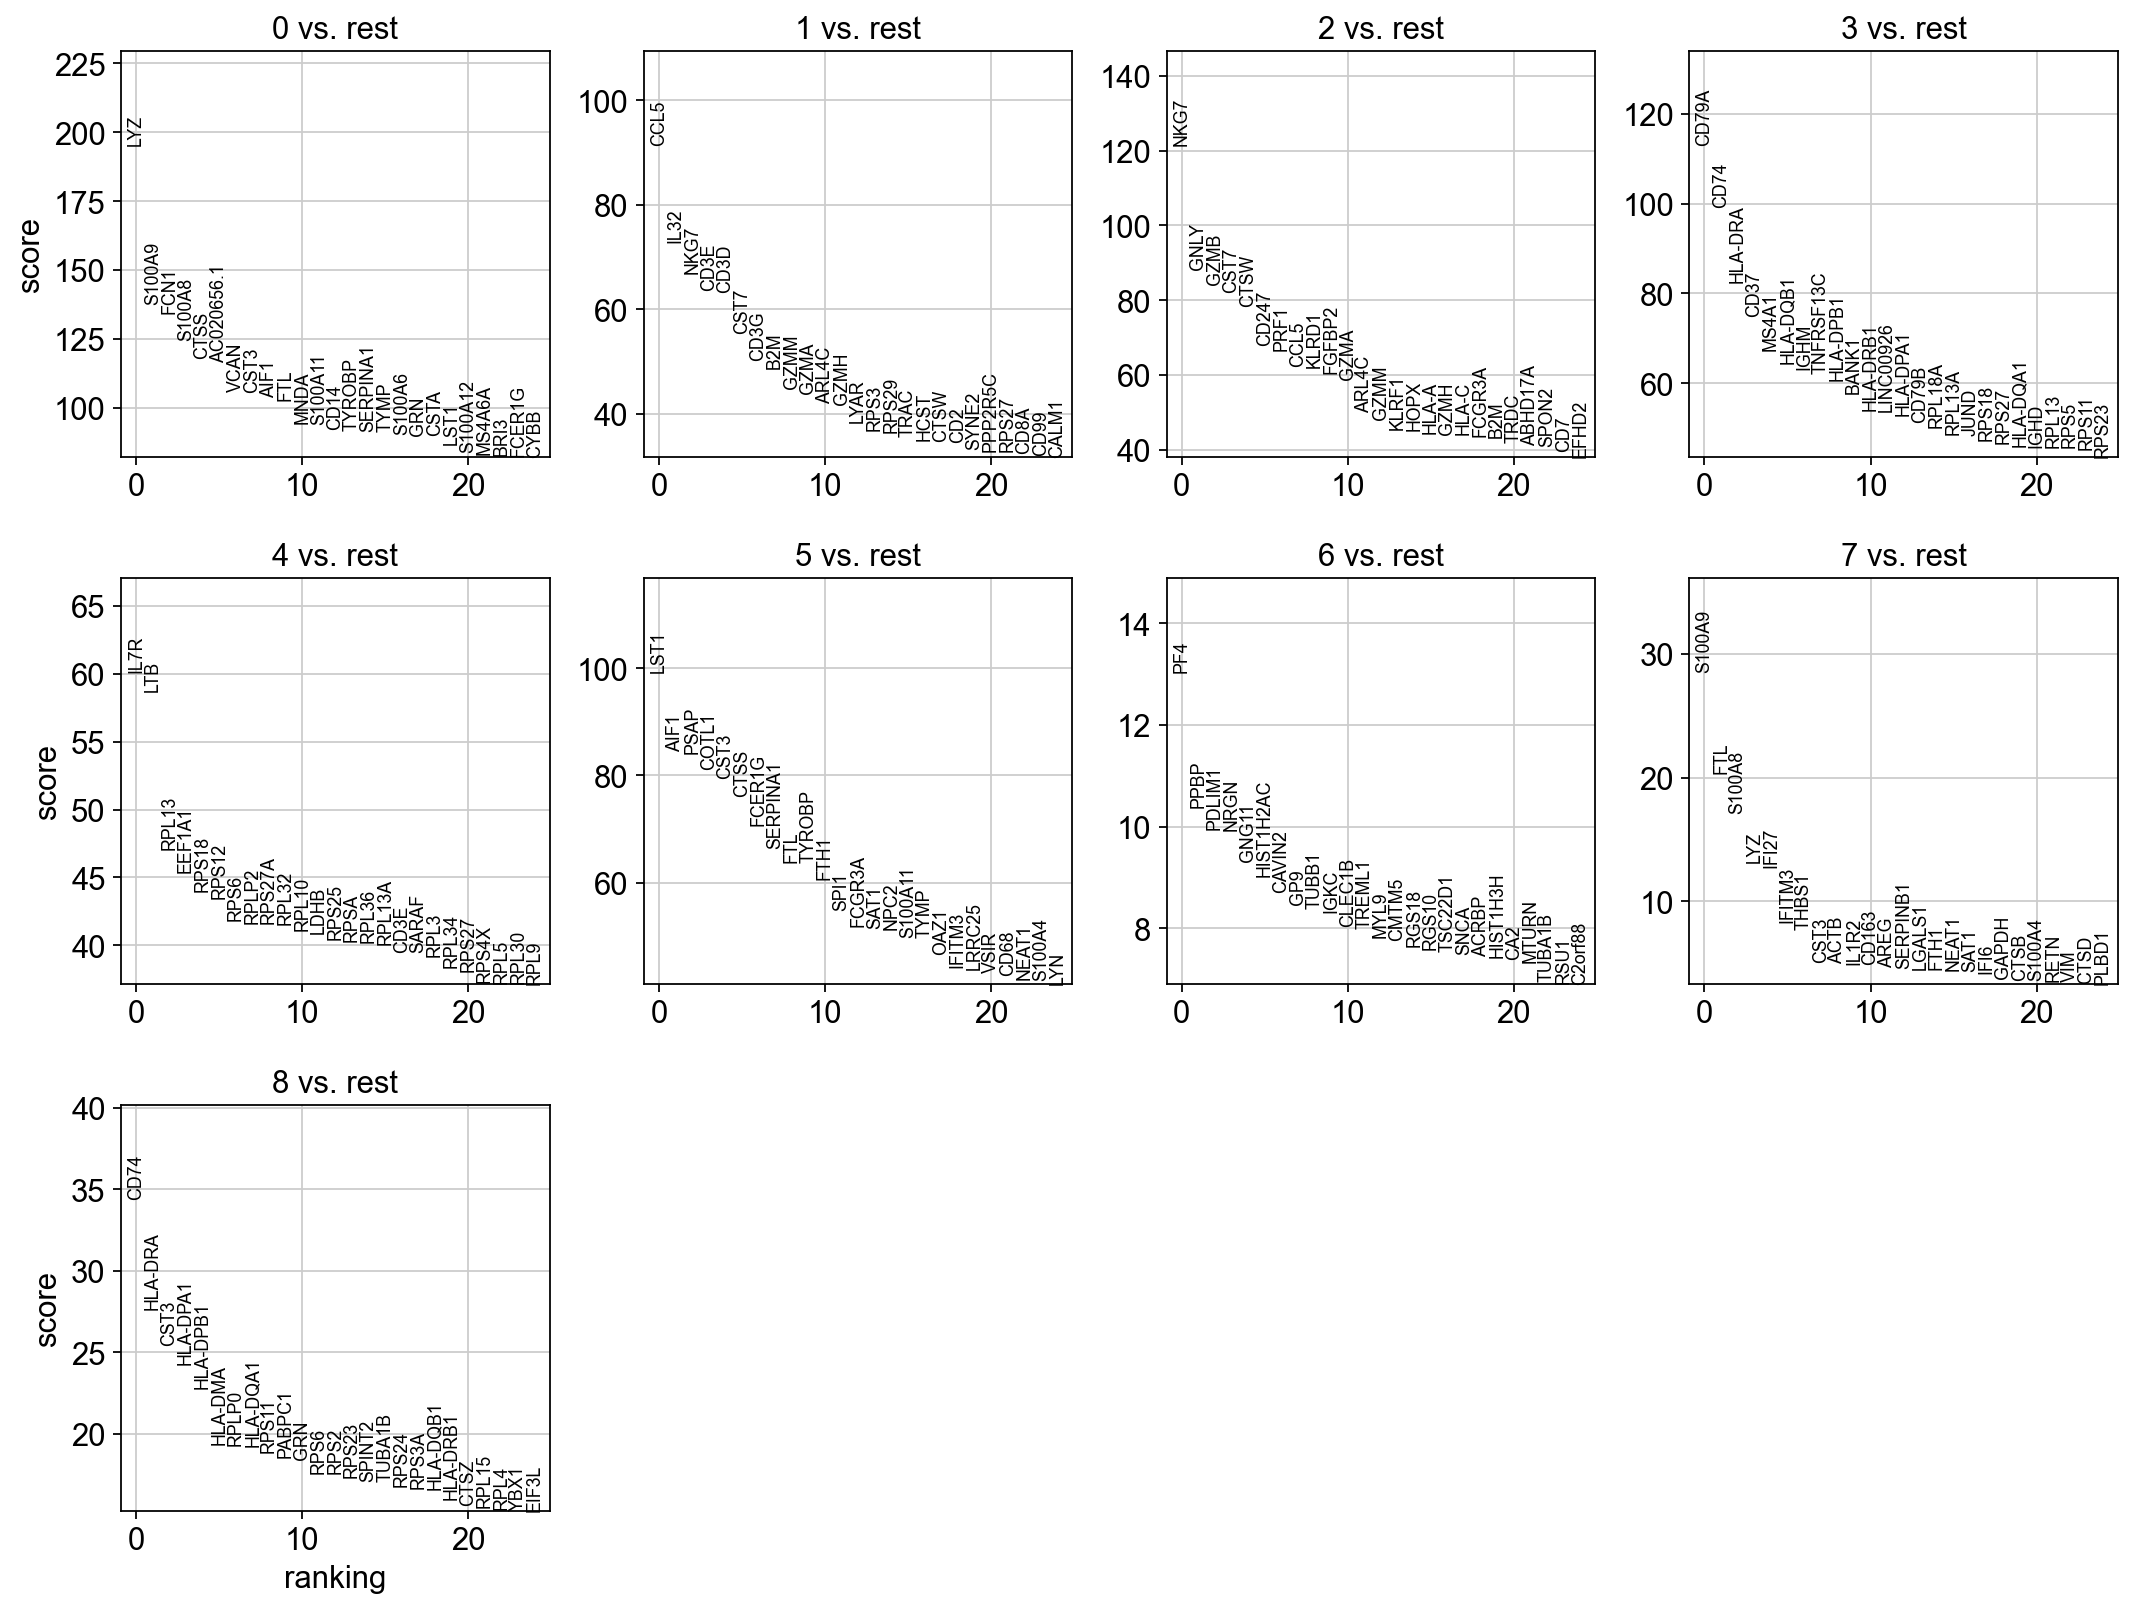

In [48]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")


In [49]:
# results are stored in the adata.uns["t-test"] slot
adata

AnnData object with n_obs × n_vars = 5594 × 18752
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden_1.0', 'leiden_0.6', 'leiden_0.4', 'leiden_1.4', 'louvain_1.0', 'louvain_0.6', 'louvain_0.4', 'louvain_1.4', 'kmeans5', 'kmeans10', 'kmeans15', 'hclust_5', 'hclust_10', 'hclust_15'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'dendrogram_leiden_0.6', 'dendrogram_louvain_0.6', 'doublet_info_colors', 'hclust_10_colors', 'hclust_15_colors', 'hclust_5_colors', 'hvg', 'kmeans10_colors', 'kmeans15_colors', 'kmeans5_colors', 'leiden', 'leiden_0.4_colors', 'leiden_0.6_colors', 'leiden_1.0_colors', 'leiden_1.4_color

### T-test overestimated_variance

ranking genes
    finished (0:00:01)


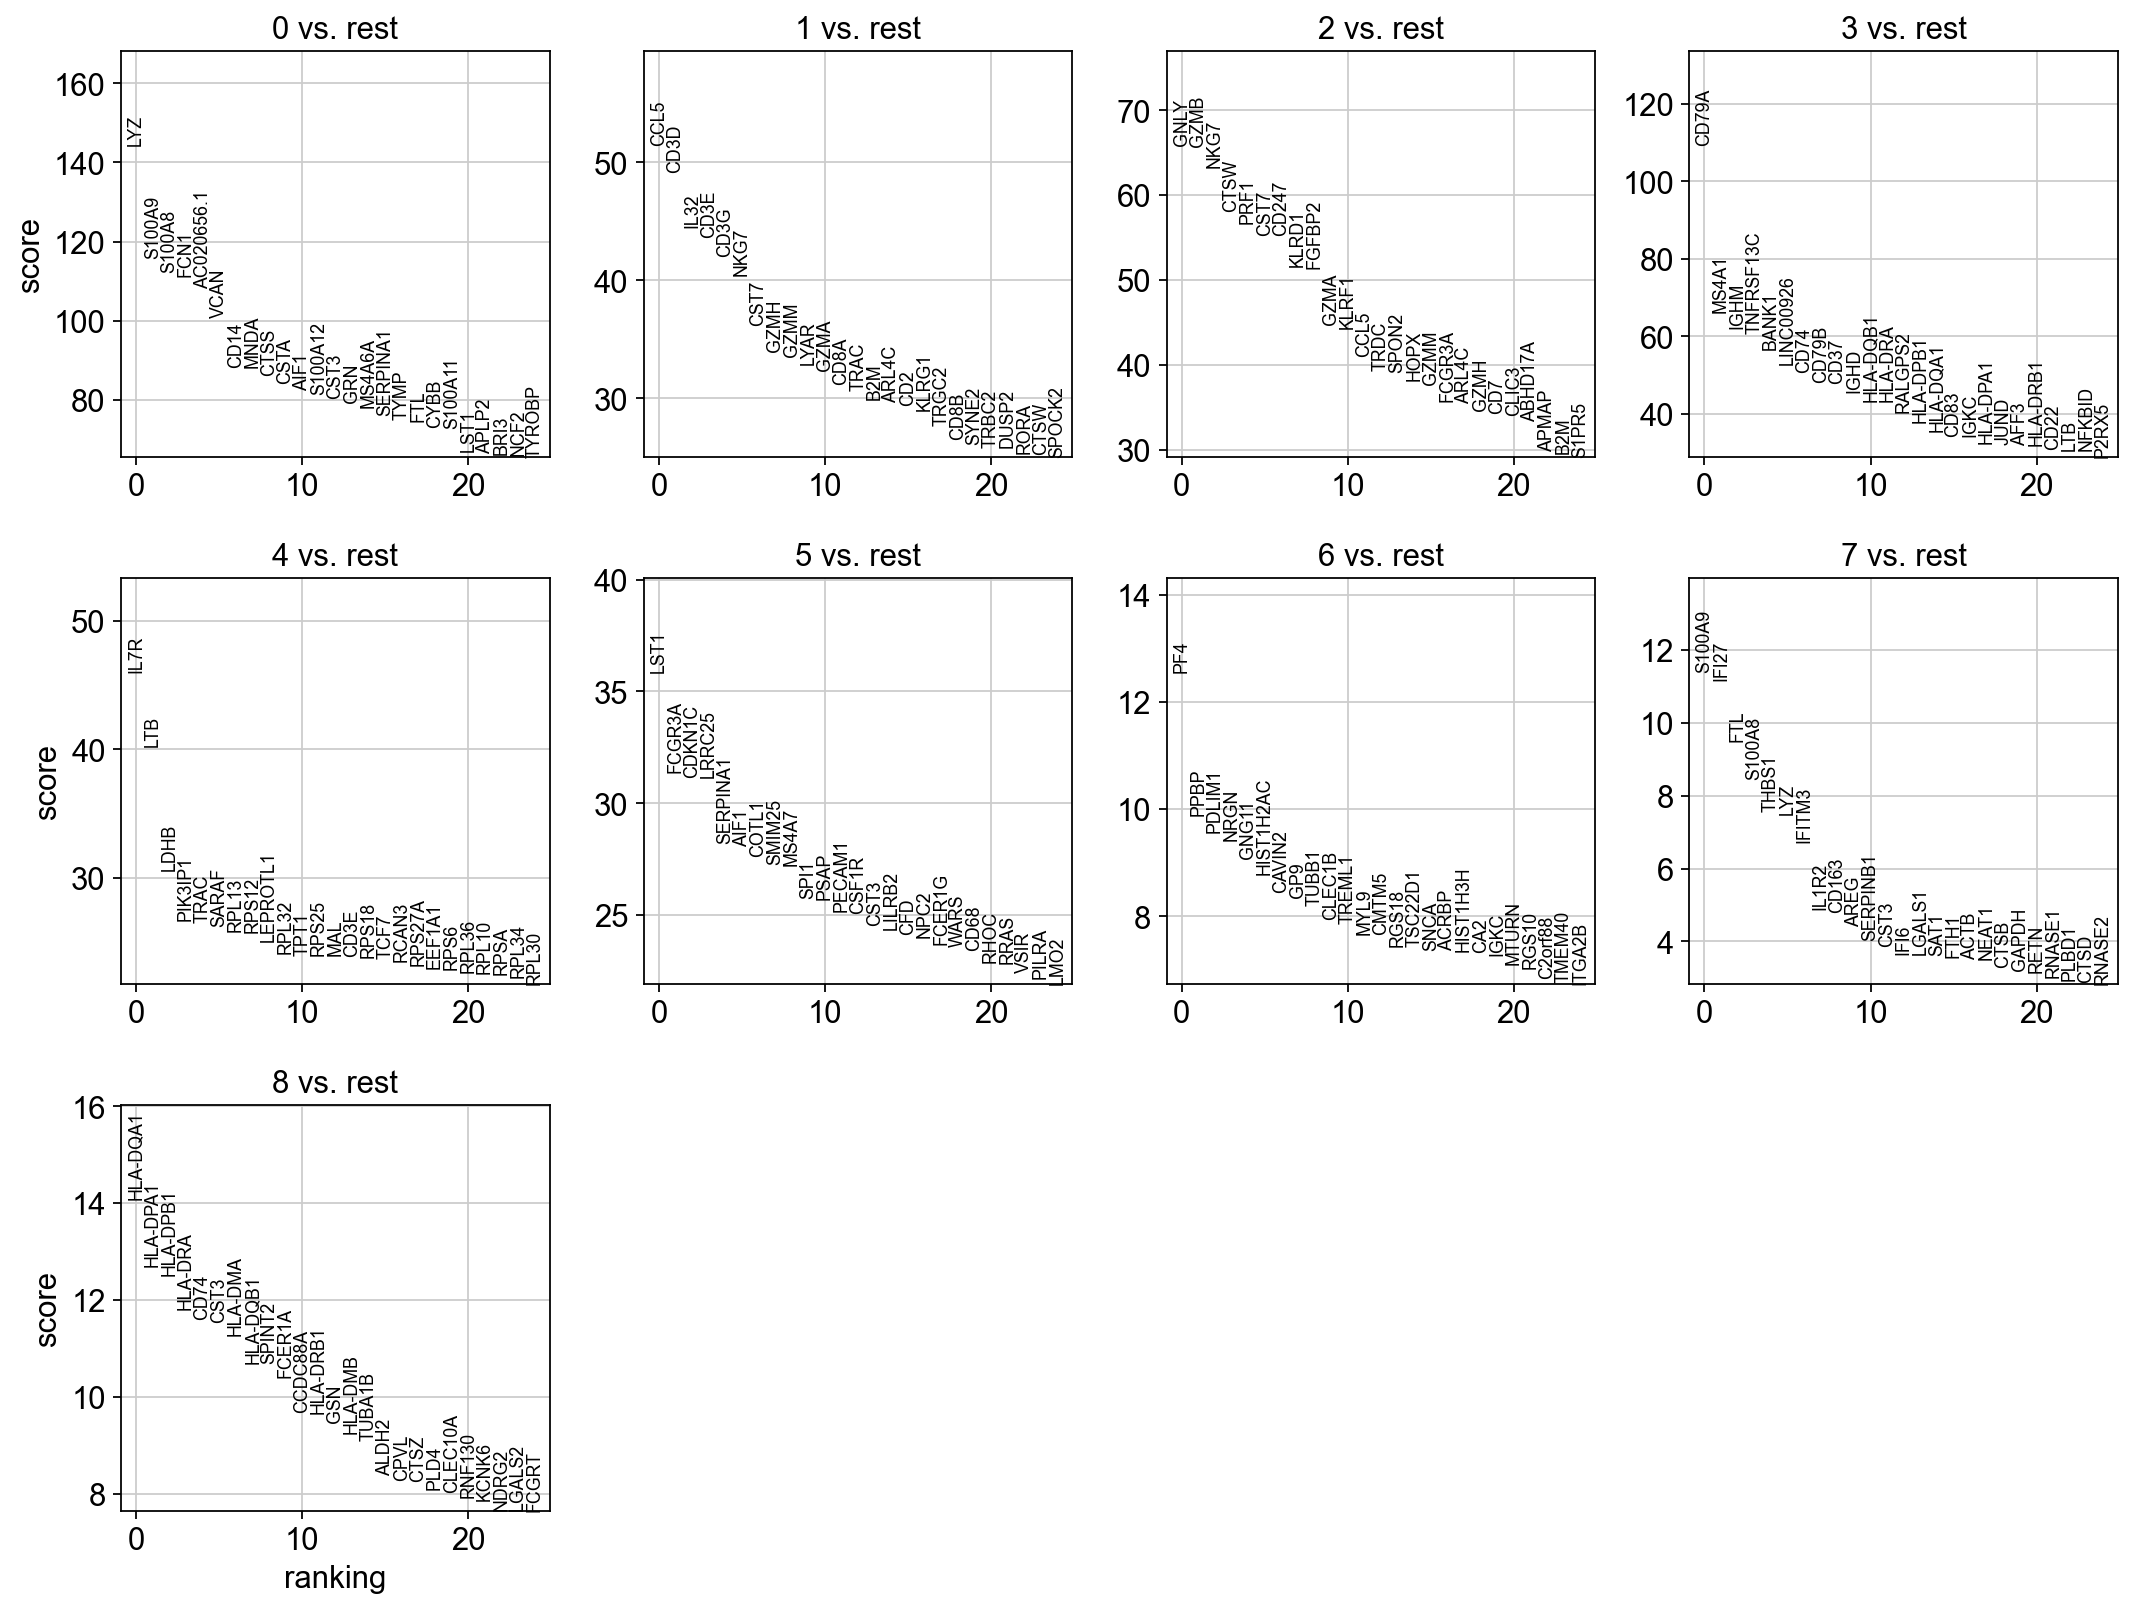

In [50]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")


### Wilcoxon rank-sum

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:08)


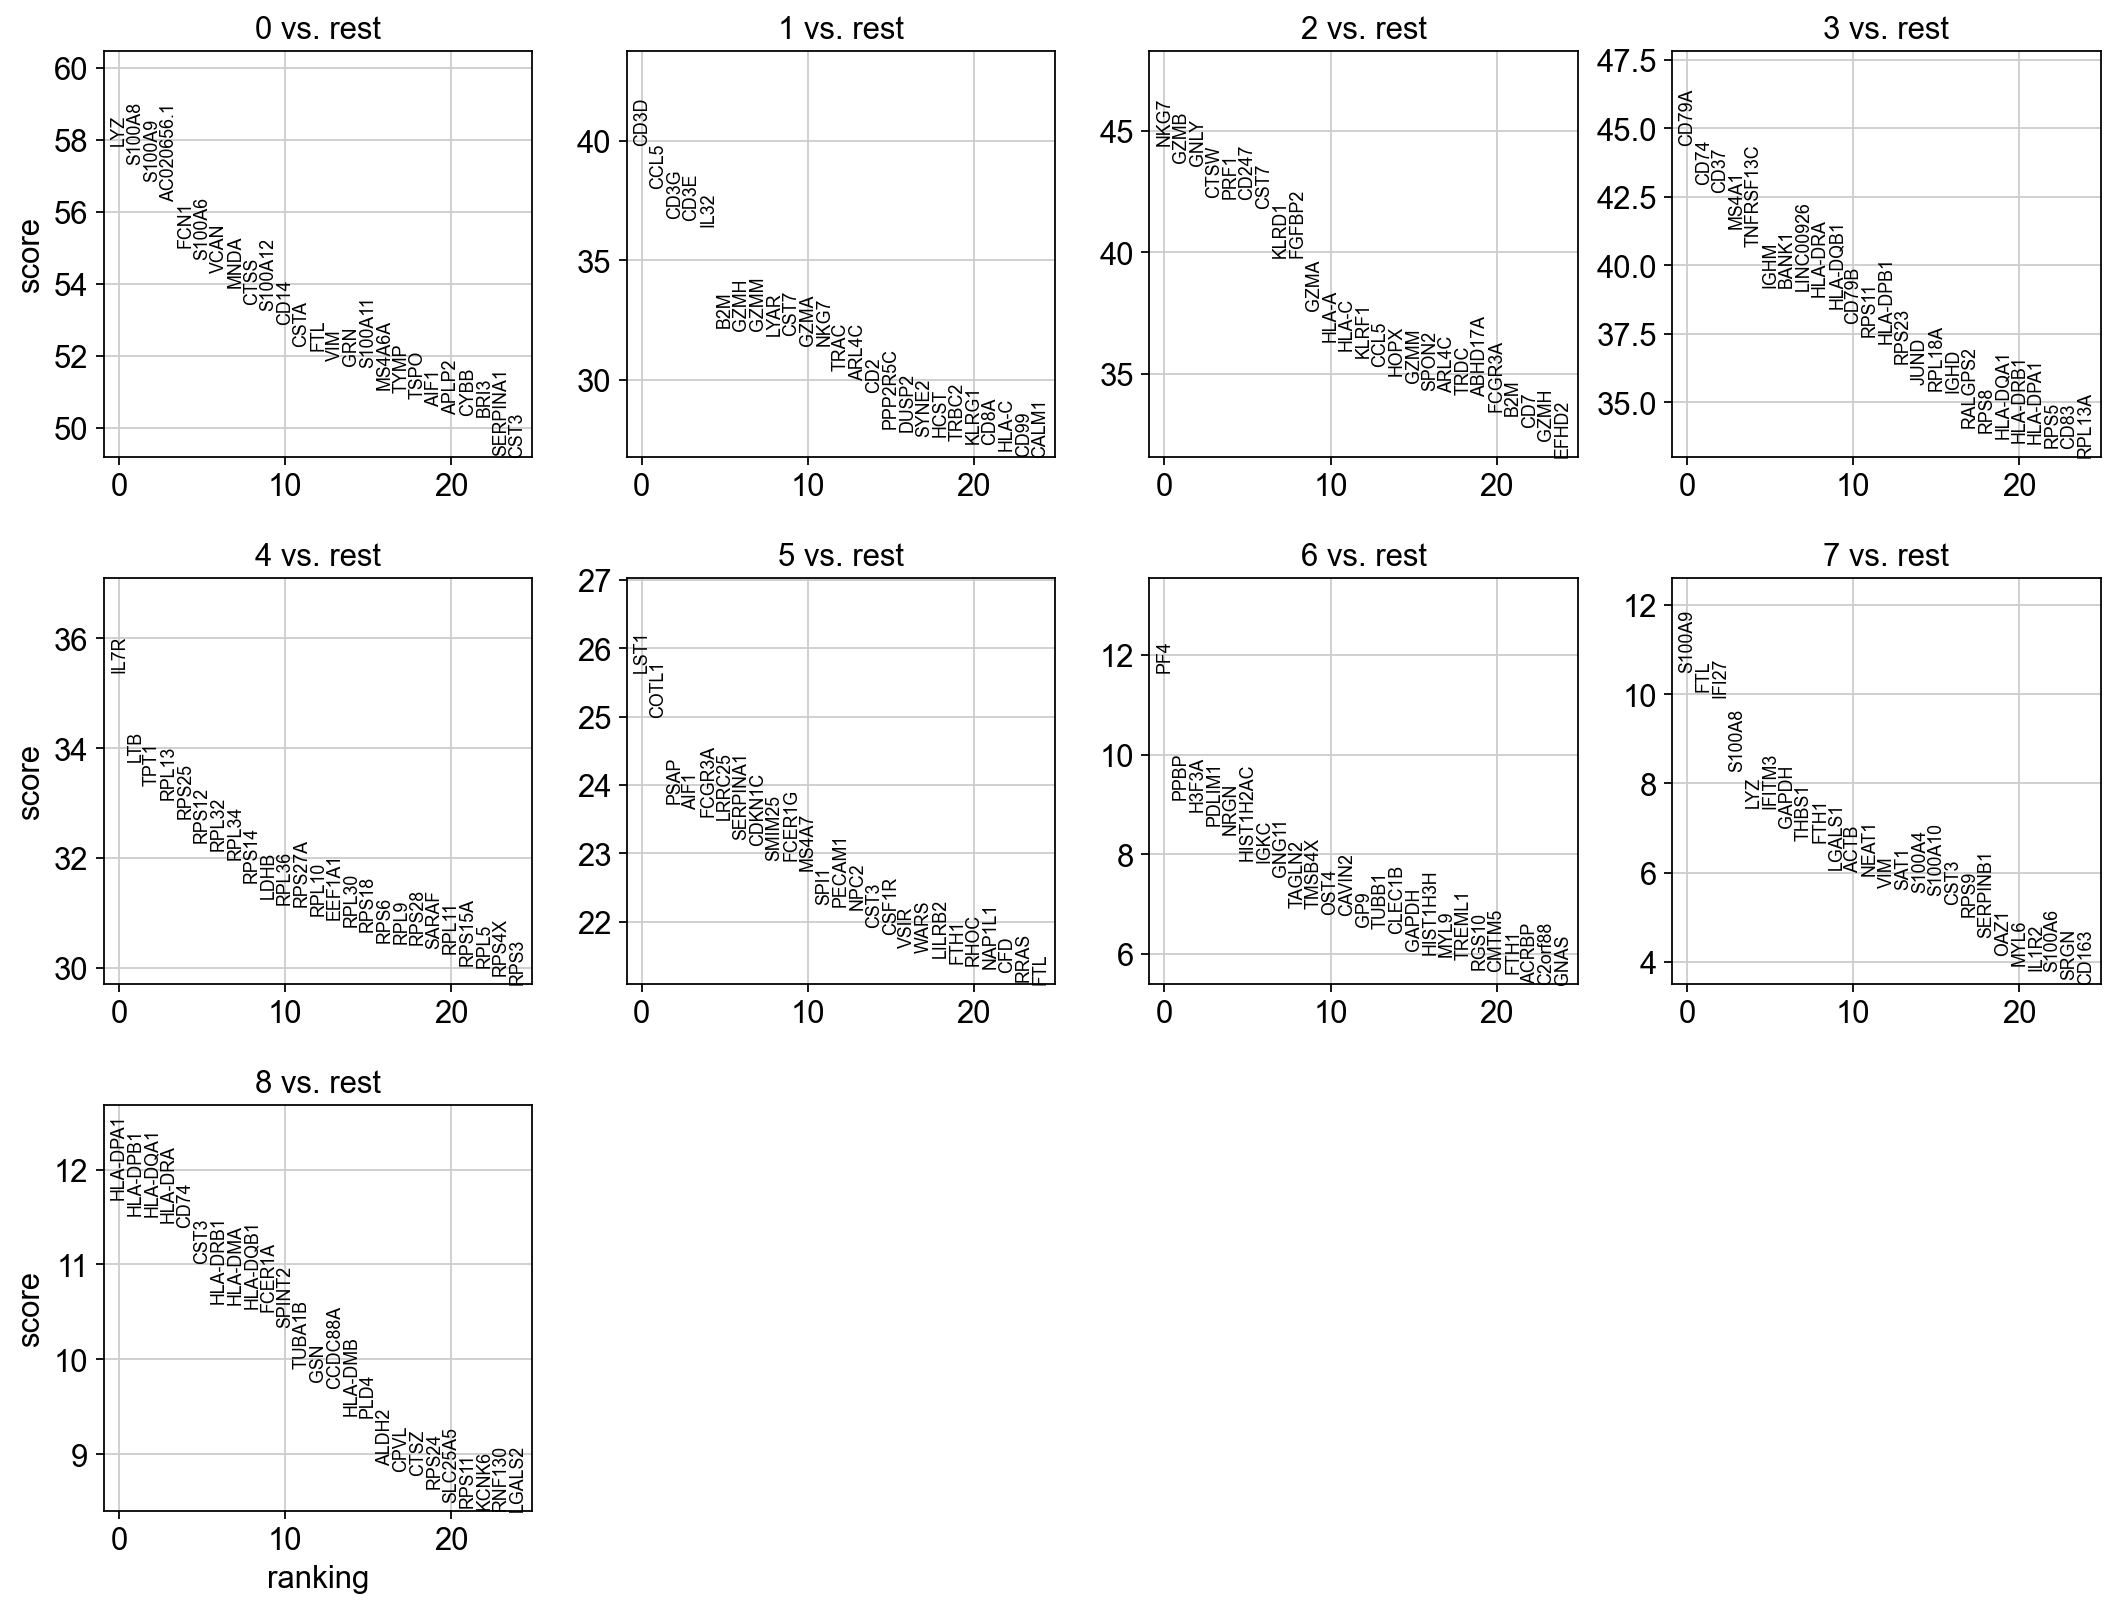

In [51]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

### Logistic regression test

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:31)


/Users/asbj/miniconda3/envs/scRNAseq2022/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


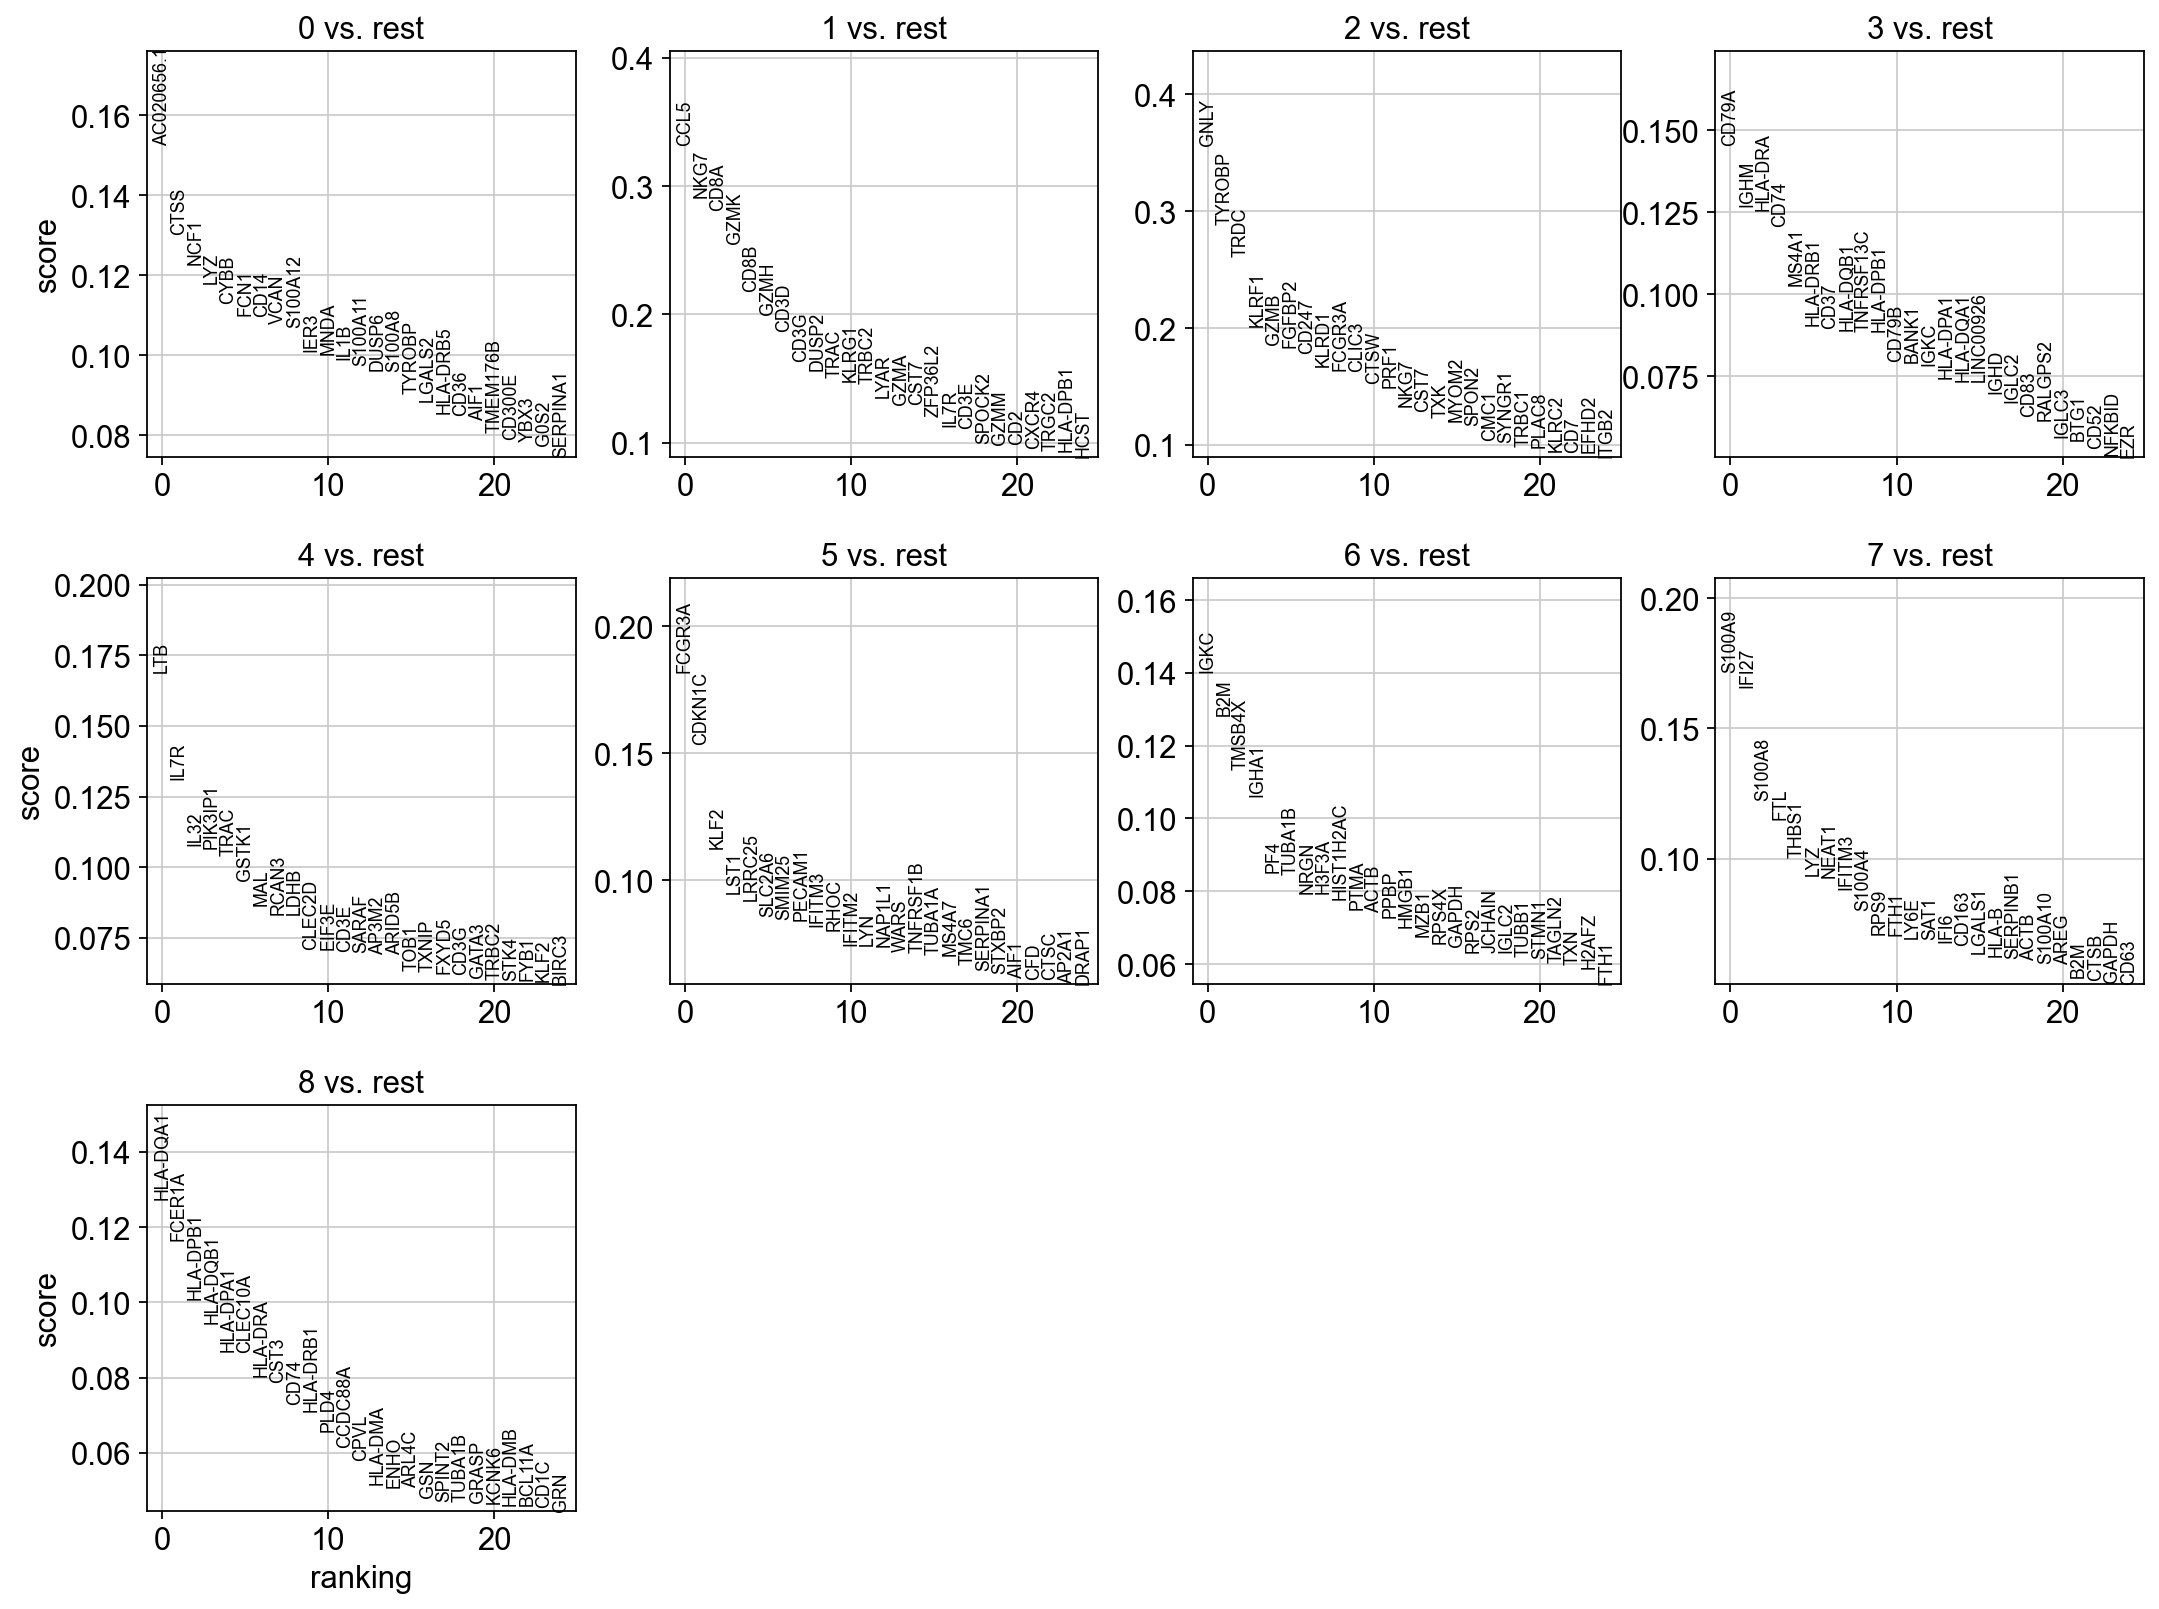

In [52]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='logreg',key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

### Compare genes

Take all significant DE genes for cluster0 with each test and compare the overlap.

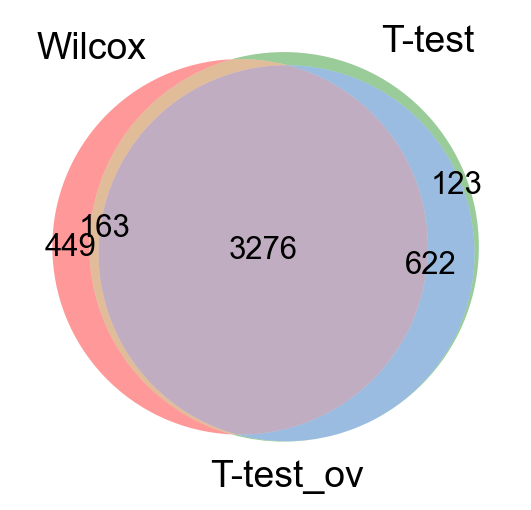

In [53]:
#compare cluster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(adata, group='0', key='t-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn3

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()



As you can see, the Wilcoxon test and the T-test with overestimated variance gives very similar result. Also the regular T-test has good overlap, while the Logistic regression gives quite different genes.

### Visualization

There are several ways to visualize the expression of top DE genes. Here we will plot top 5 genes per cluster from Wilcoxon test as heatmap, dotplot, violin plot or matrix.

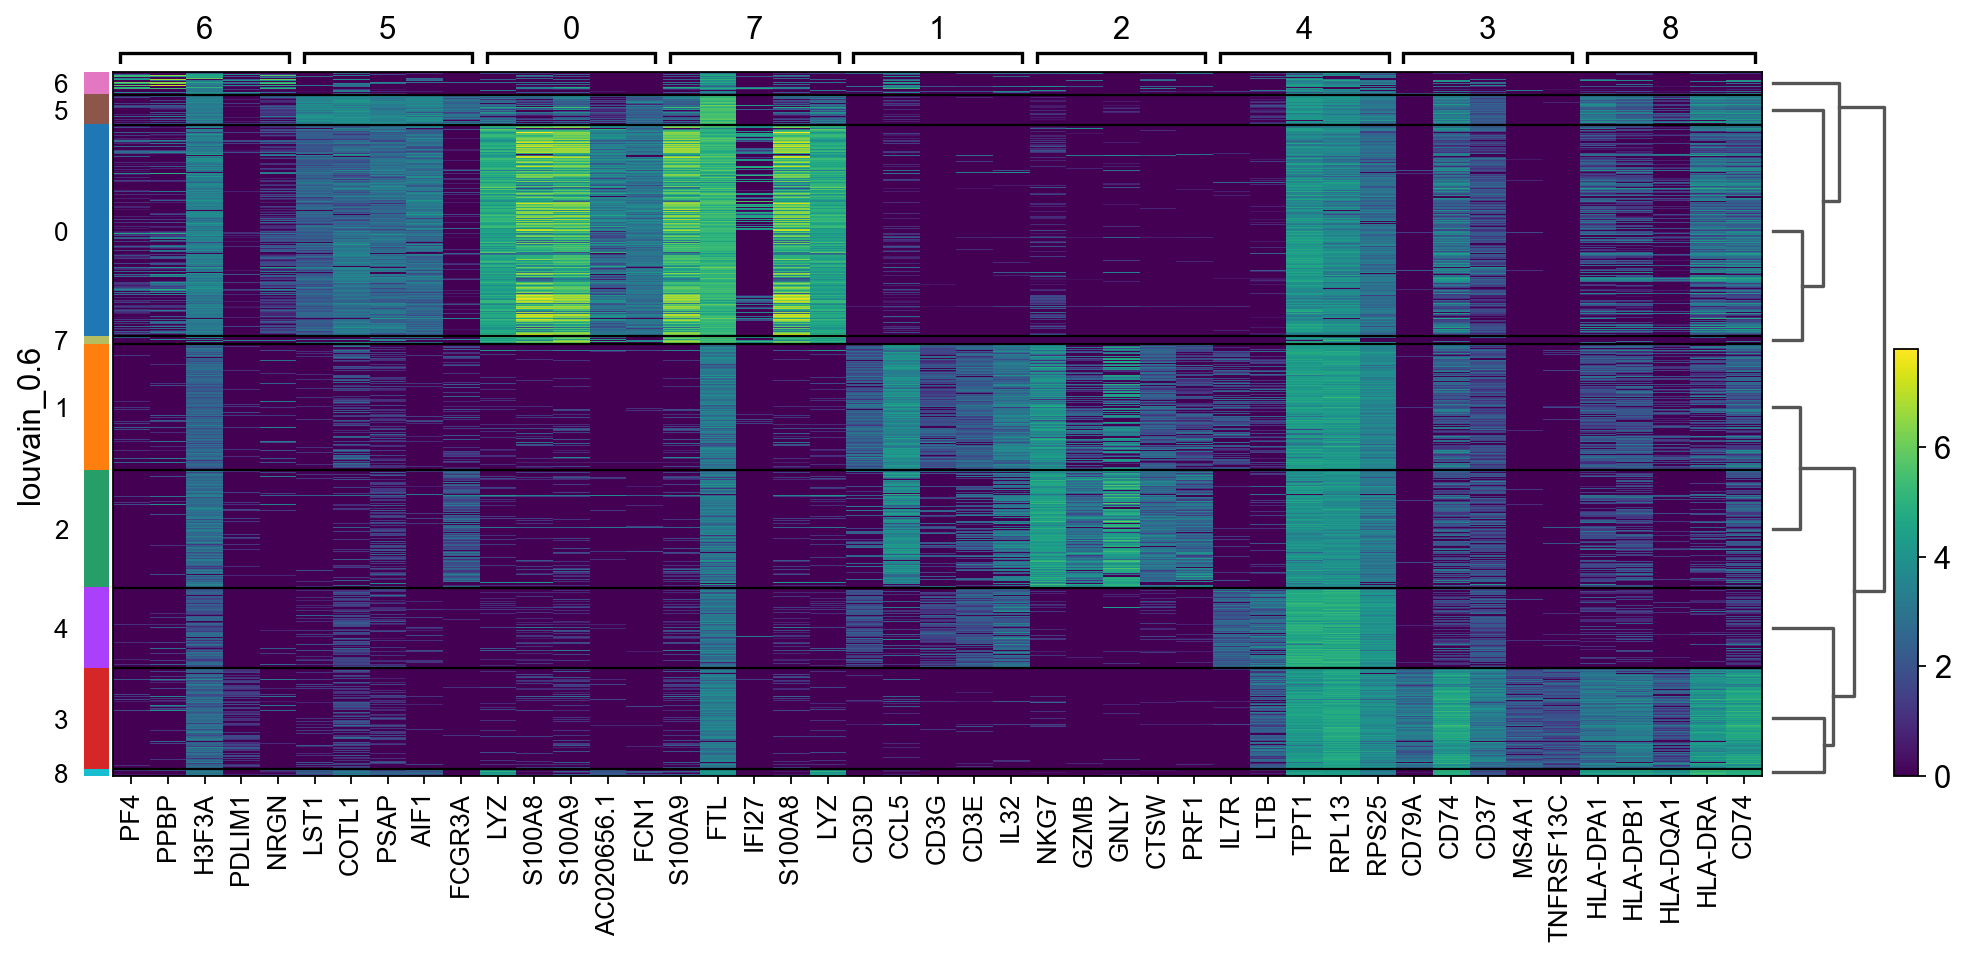

In [54]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6", show_gene_labels=True)

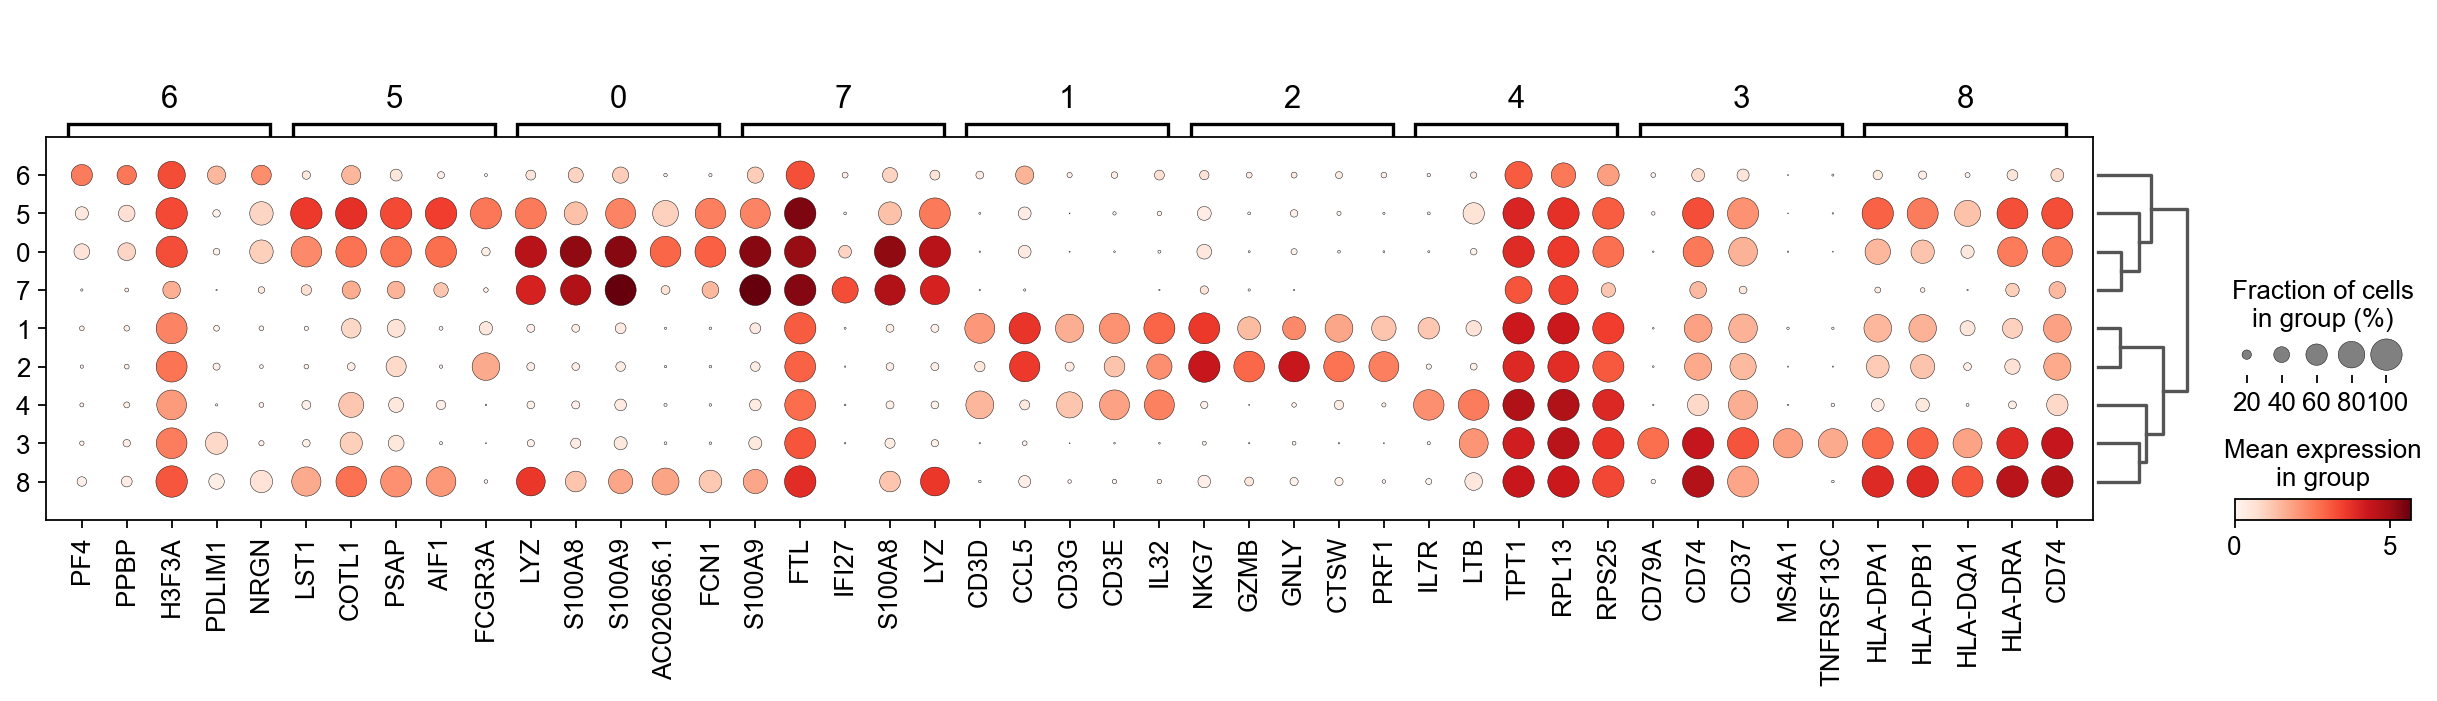

In [55]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

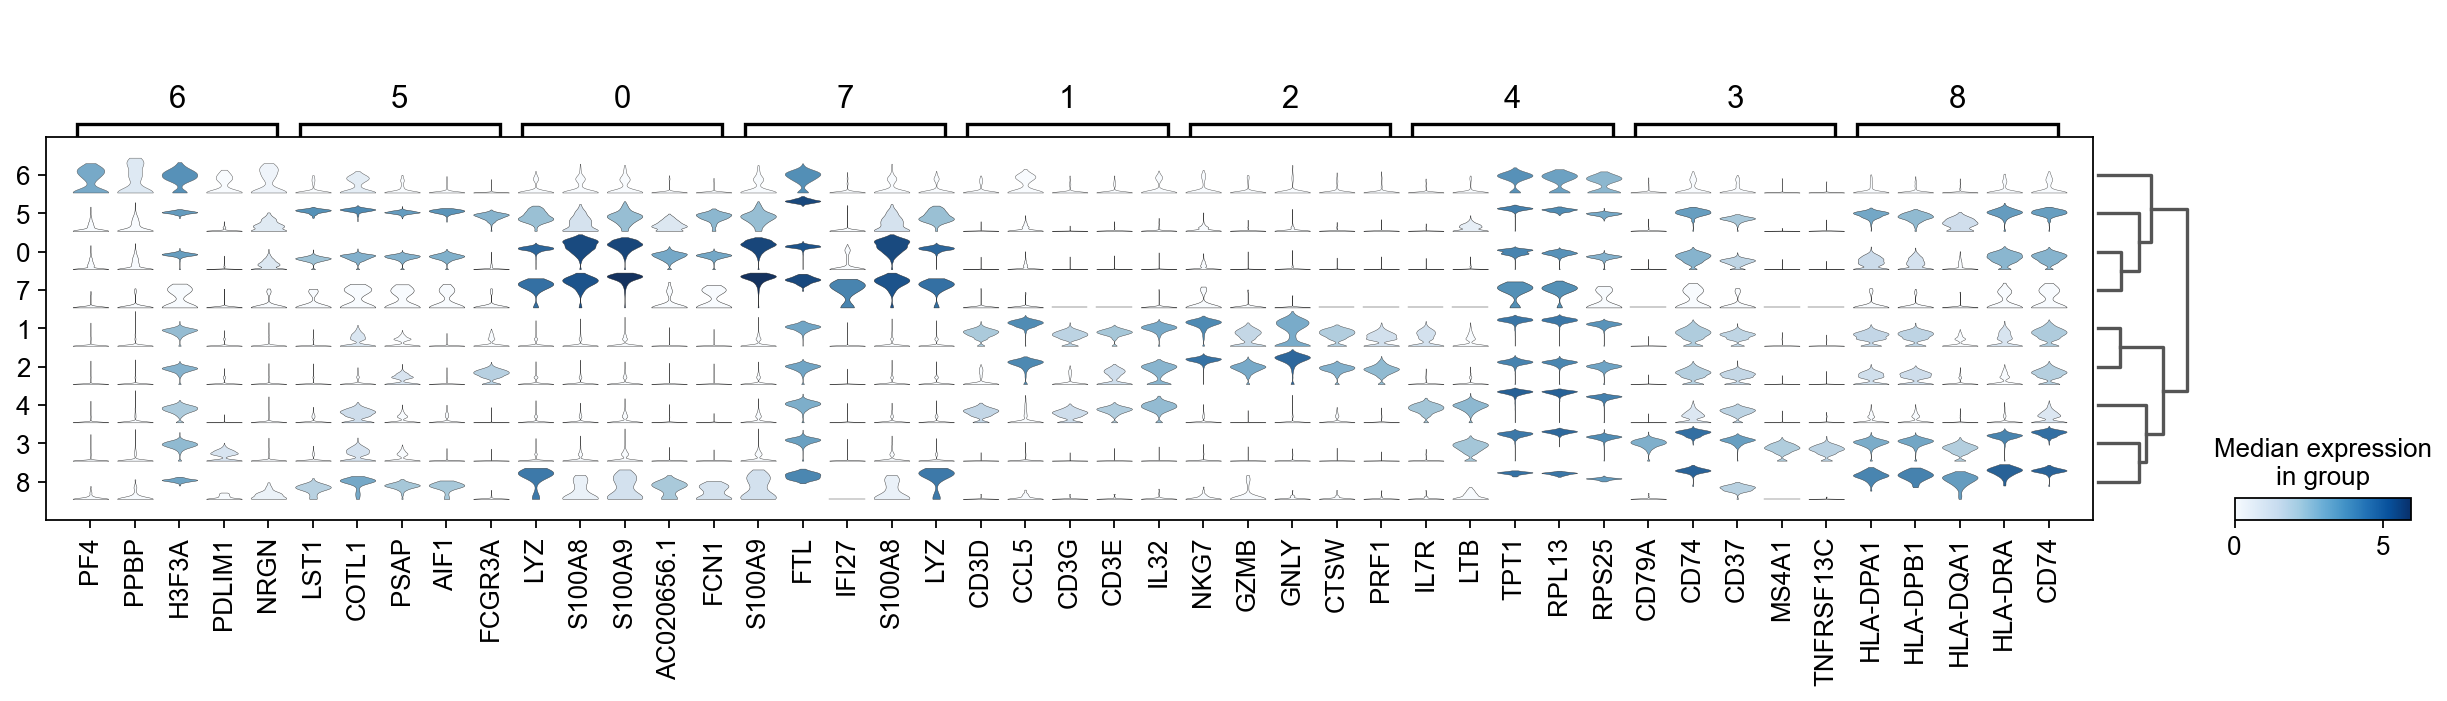

In [56]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

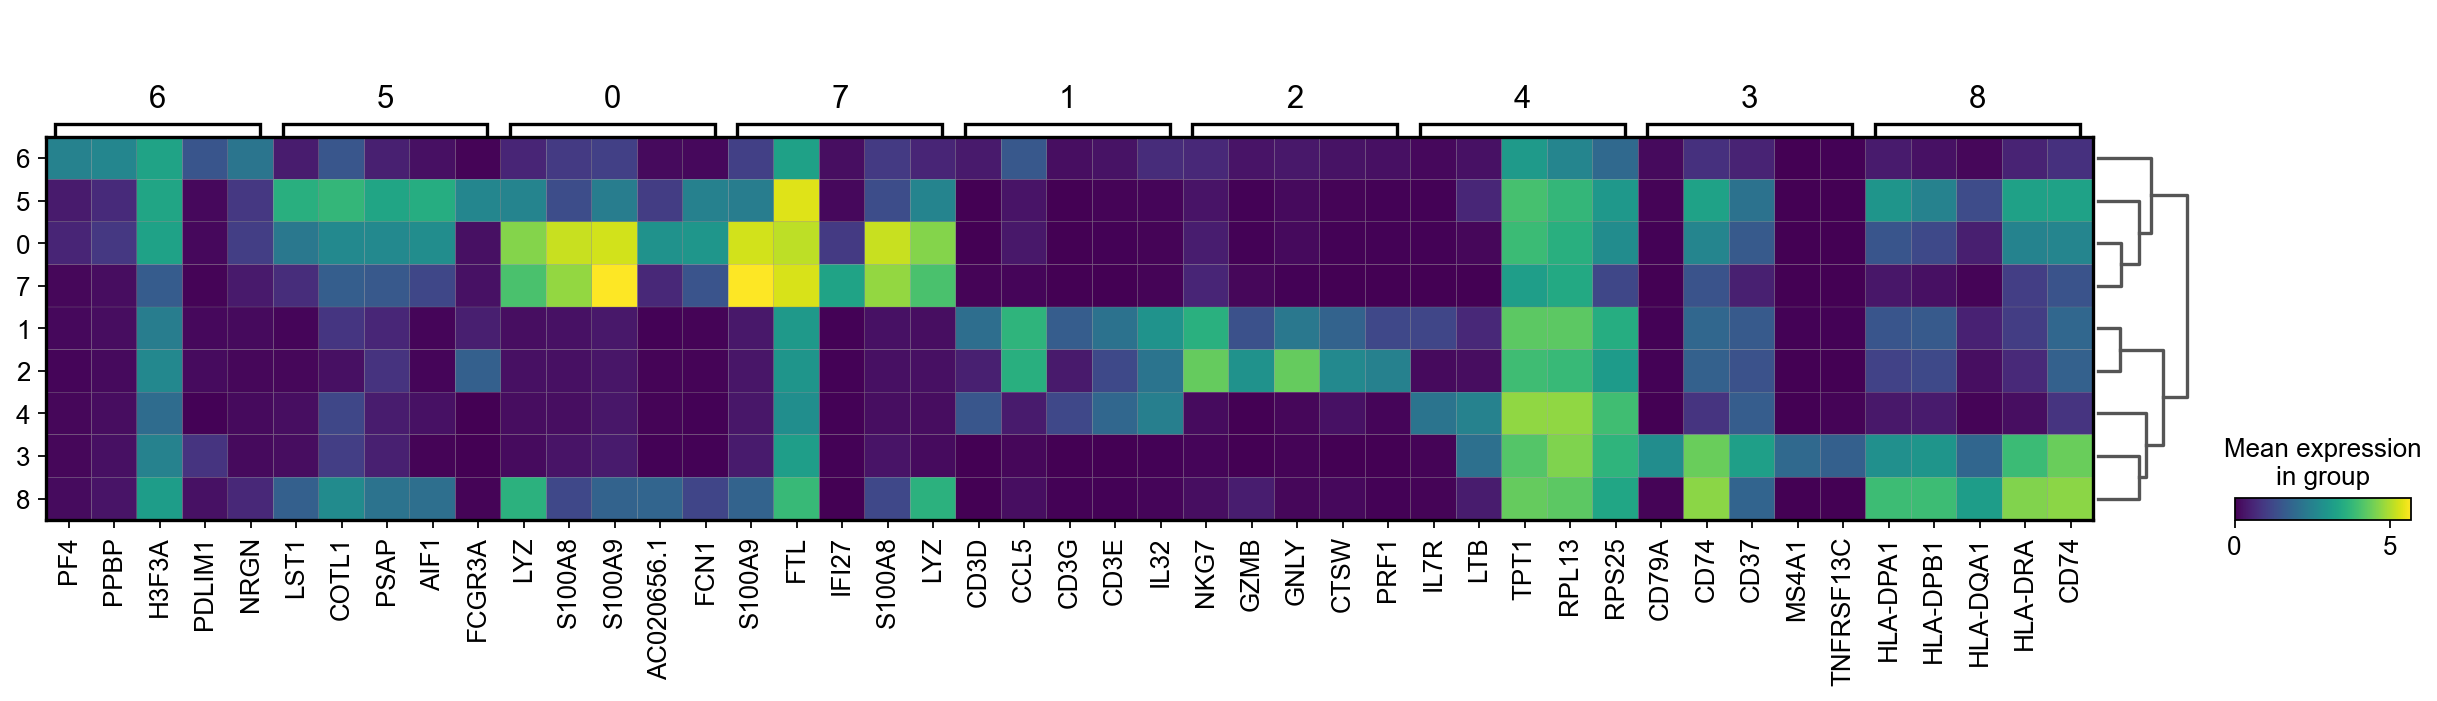

In [57]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

### Compare specific clusters

We can also do pairwise comparisons of individual clusters on one vs many clusters. 

For instance, clusters 1 & 2 have very similar expression profiles.

ranking genes
    finished (0:00:02)


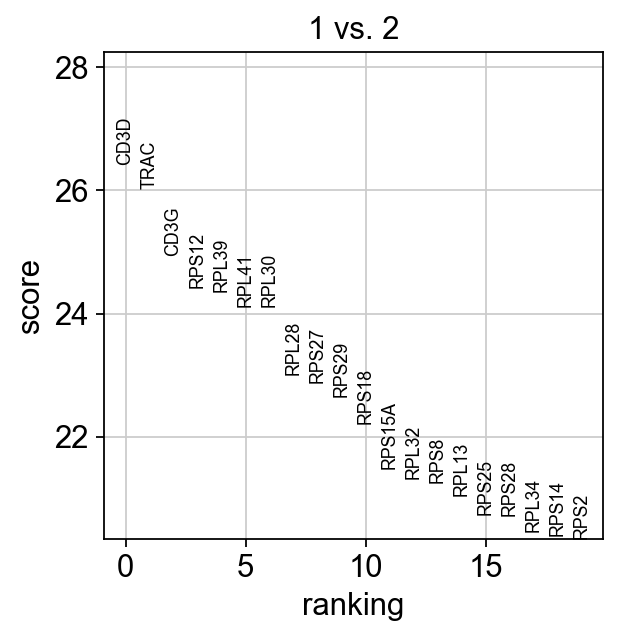

In [58]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', groups=['1'], reference='2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20)

Plot as violins for those two groups.

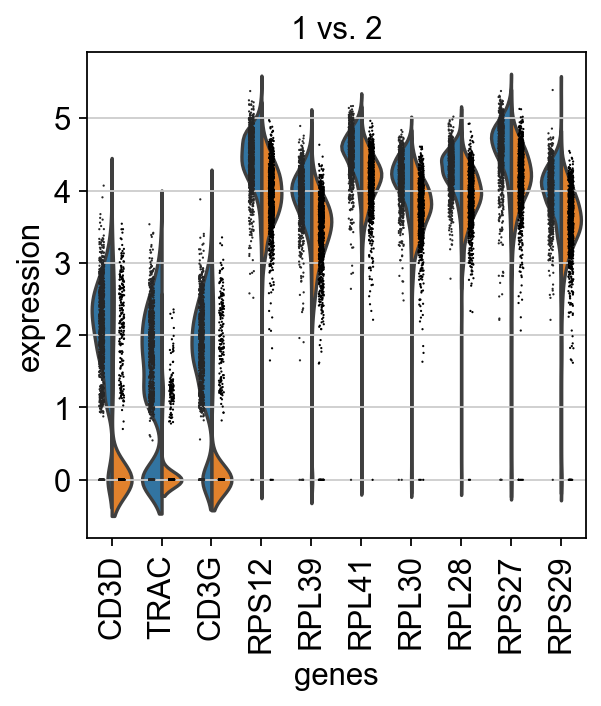

In [59]:
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=10)


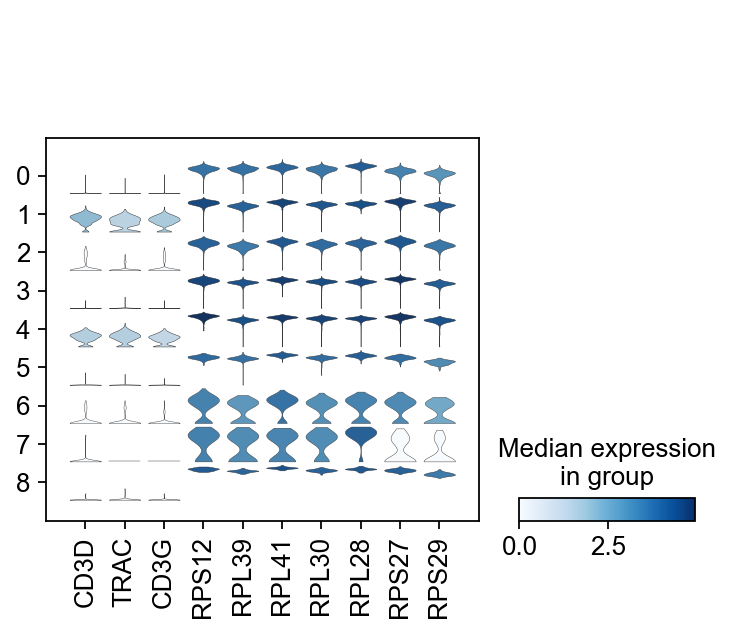

In [60]:
# plot the same genes as violins across all the datasets.

# convert numpy.recarray to list
mynames = [x[0] for x in adata.uns['rank_genes_groups']['names'][:10]]
sc.pl.stacked_violin(adata, mynames, groupby = 'louvain_0.6')


#DGE_TITLE2:

#DGE_ALL6:

In [61]:
cl1 = adata[adata.obs['louvain_0.6'] == '1',:]
cl1.obs['type'].value_counts()

Ctrl     693
Covid    305
Name: type, dtype: int64

ranking genes


Trying to set attribute `._uns` of view, copying.


    finished (0:00:01)


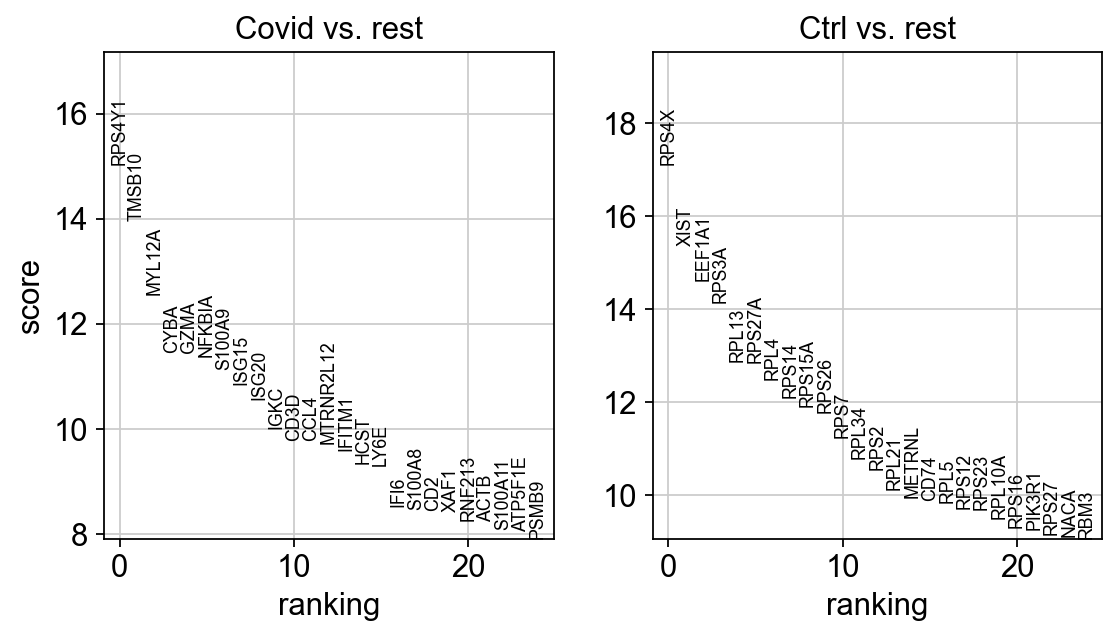

In [62]:
sc.tl.rank_genes_groups(cl1, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key="wilcoxon")

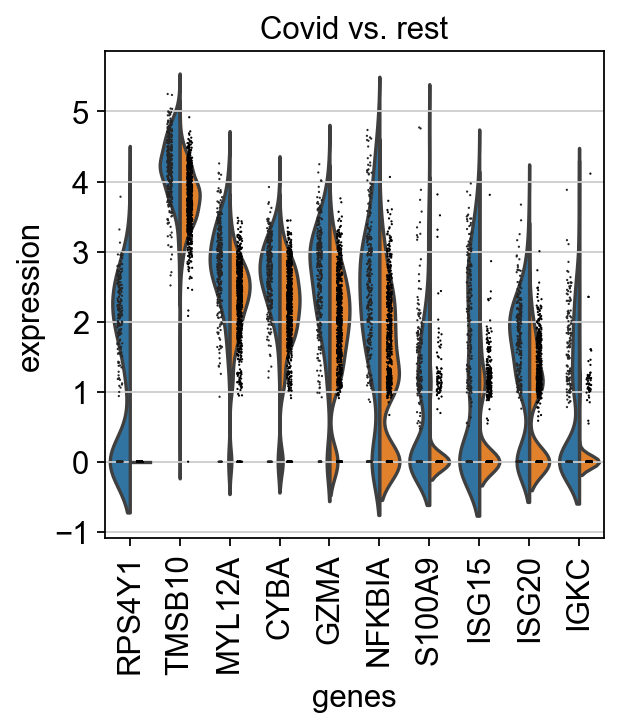

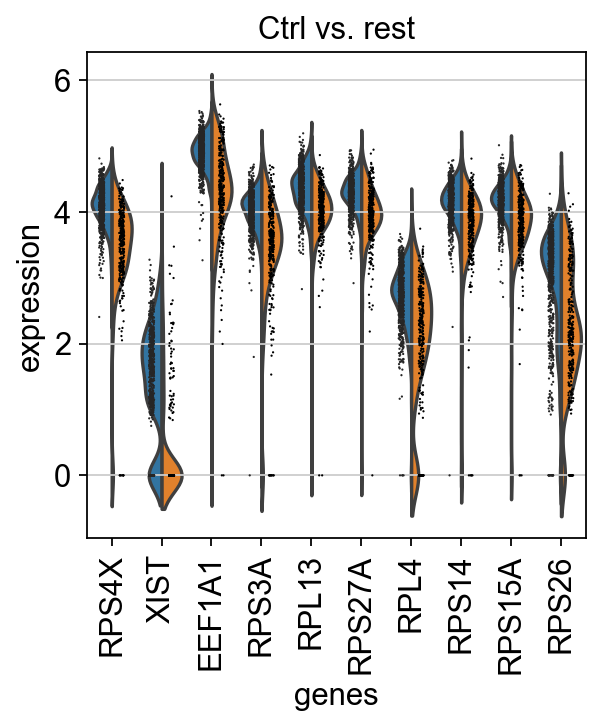

In [63]:
sc.pl.rank_genes_groups_violin(cl1, n_genes=10, key="wilcoxon")


#DGE_ALL6.1b:

In [65]:
import seaborn as sns

genes1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')['names'][:5]
genes2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')['names'][:5]
genes = genes1.tolist() +  genes2.tolist() 
df = sc.get.obs_df(adata, genes + ['louvain_0.6','type'], use_raw=False)
df2 = df.melt(id_vars=["louvain_0.6",'type'], value_vars=genes)



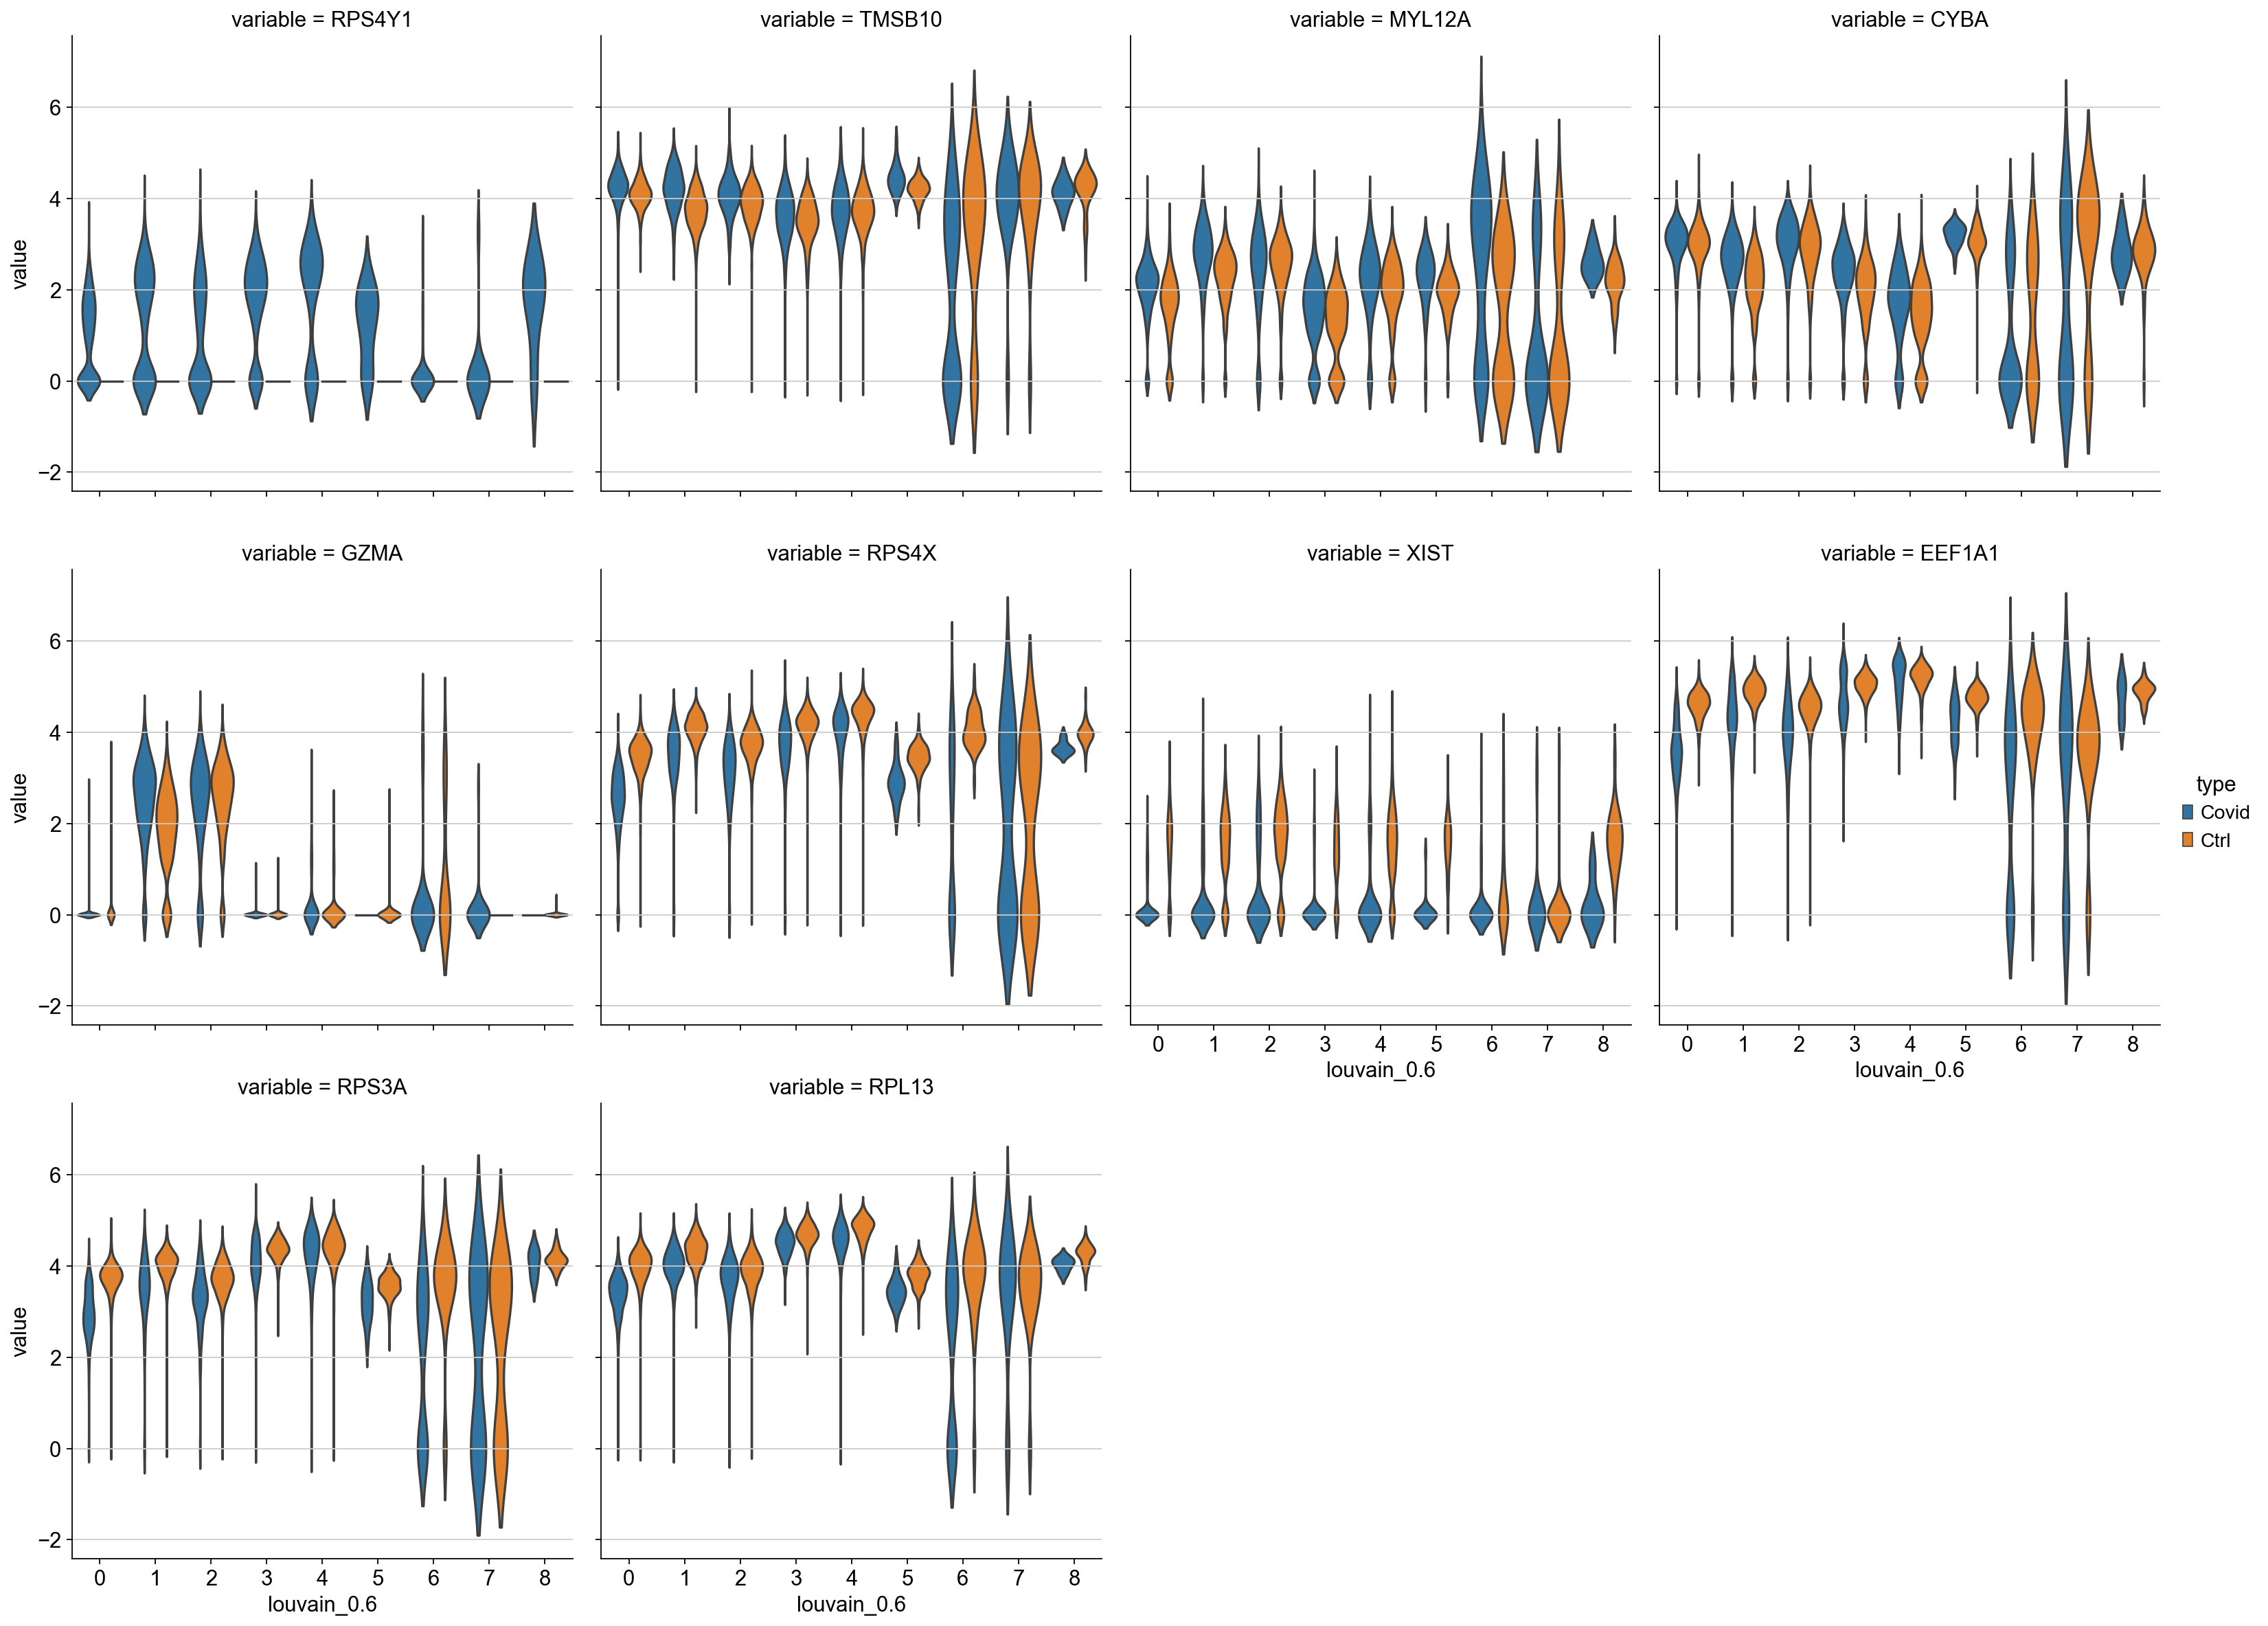

In [66]:
sns.catplot(x = "louvain_0.6", y = "value", hue = "type", kind = 'violin', 
               col = "variable", data = df2, col_wrap=4, inner=None)

#DGE_TITLE3:

#DGE_TITLE3.1:

#DGE_ALL7:

In [67]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease_Perturbations_from_GEO_up', 'Disease_Signatures

Get the significant DEGs.

In [72]:
#?gseapy.enrichr
glist = sc.get.rank_genes_groups_df(cl1, group='Covid', 
                                    key='wilcoxon', log2fc_min=0.25, 
                                    pval_cutoff=0.01)['names'].squeeze().str.strip().tolist()
print(len(glist))

164


In [74]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2018',
                     description='pathway',
                     cutoff = 0.5)

In [75]:
enr_res.results.head()

Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap       P-value  \
0  cellular response to type I interferon (GO:007...   15/65  3.862744e-18   
1   type I interferon signaling pathway (GO:0060337)   15/65  3.862744e-18   
2   cytokine-mediated signaling pathway (GO:0019221)  33/633  1.314537e-17   
3  mitochondrial ATP synthesis coupled electron t...   10/85  1.923650e-09   
4  respiratory electron transport chain (GO:0022904)   10/94  5.217930e-09   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      2.559068e-15            0                     0   39.837584   
1      2.559068e-15            0                     0   39.837584   
2      5.805873e-15            0                     0    8.076183   
3      6.372089e-07            0                     0   17.109091   
4      1.382752e-06            0                     0   15.269017   

   Combined Score                                              Genes  
0     1597.294054  IFITM1;SP100;STAT1;MX1;IFI6;ISG15;IFI35;SAMHD1...  
1     1597.294054  IFITM1;SP100;STAT1;MX1;IFI6;ISG15;IFI35;SAMHD1...  
2      313.924971  IFITM1;SP100;IFI6;IFI35;SAMHD1;PSMB10;IFIT3;PS...  
3      343.363058  COX7B;NDUFA12;NDUFA4;NDUFA3;NDUFB3;NDUFB2;UQCR...  
4      291.197936  COX7B;NDUFA12;NDUFA4;NDUFA3;NDUFB3;NDUFB2;UQCR...

#DGE_ALL7.1:

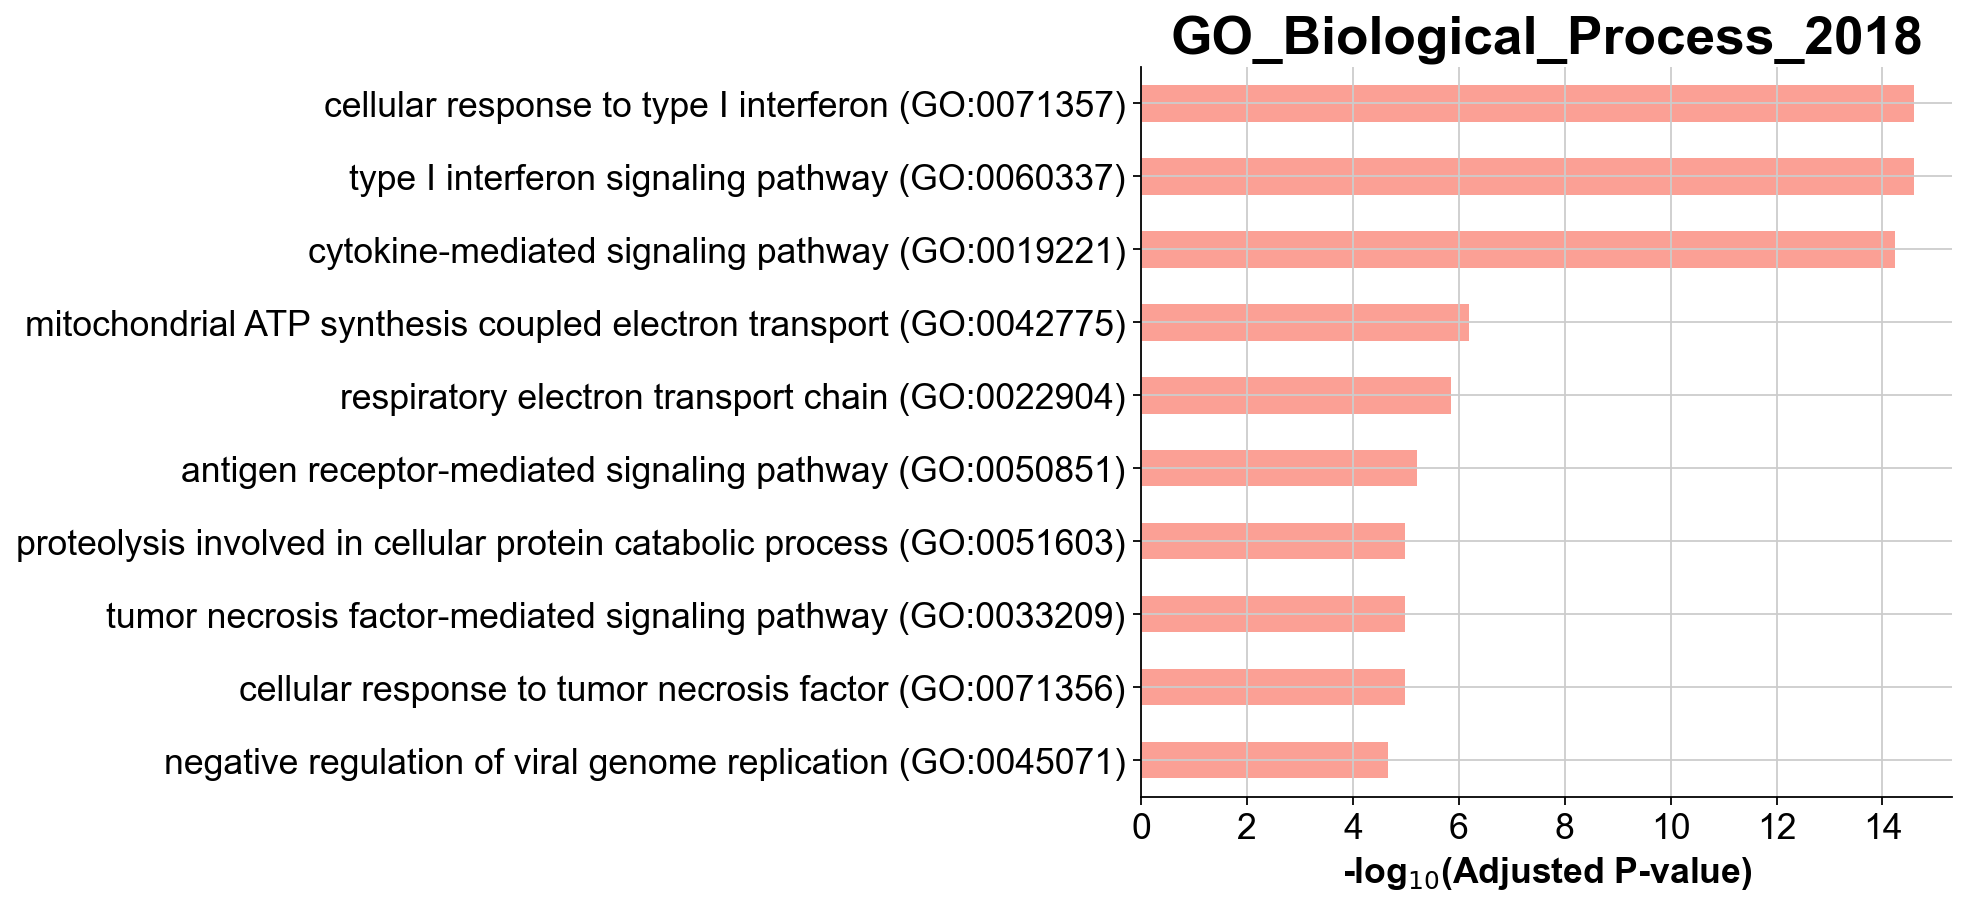

In [77]:
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2018')

#DGE_TITLE3.2:

#DGE_ALL7.2:


We need a table with all DEGs and their log foldchanges. However, many lowly expressed genes will have high foldchanges and just contribue noise, so also filter for expression in enough cells. 

In [124]:
gene_rank = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

In [125]:
# calculate_qc_metrics will calculate number of cells per gene
sc.pp.calculate_qc_metrics(cl1, percent_top=None, log1p=False, inplace=True)

# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(cl1.var_names[cl1.var.n_cells_by_counts>30])]


In [126]:
gene_rank

names  logfoldchanges
0          RPS4Y1       31.311884
36          DDX3Y       28.709471
90         EIF1AY       27.923817
166        TTTY15       27.691143
264           UTY       27.231516
...           ...             ...
18062      PHLDA1       -2.782725
18422        WHRN       -2.796236
18750        XIST       -2.828403
17578       CRIP2       -4.180913
18336  AC004556.1      -26.813562

[8433 rows x 2 columns]

#DGE_ALL7.3:

In [127]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease_Perturbations_from_GEO_up', 'Disease_Signatures

#DGE_ALL7.4:

In [128]:
res = gseapy.prerank(rnk=gene_rank, gene_sets='KEGG_2021_Human')

In [129]:
terms = res.res2d.index
terms[:20]

Index(['Viral protein interaction with cytokine and cytokine receptor',
       'Leukocyte transendothelial migration', 'Necroptosis',
       'Fatty acid degradation', 'Rheumatoid arthritis', 'Toxoplasmosis',
       'Epstein-Barr virus infection', 'Pertussis',
       'JAK-STAT signaling pathway', 'Retrograde endocannabinoid signaling',
       'RNA transport',
       'Epithelial cell signaling in Helicobacter pylori infection',
       'Drug metabolism', 'Mismatch repair', 'Ribosome', 'Legionellosis',
       'AGE-RAGE signaling pathway in diabetic complications',
       'Chemokine signaling pathway', 'Yersinia infection', 'Proteasome'],
      dtype='object', name='Term')

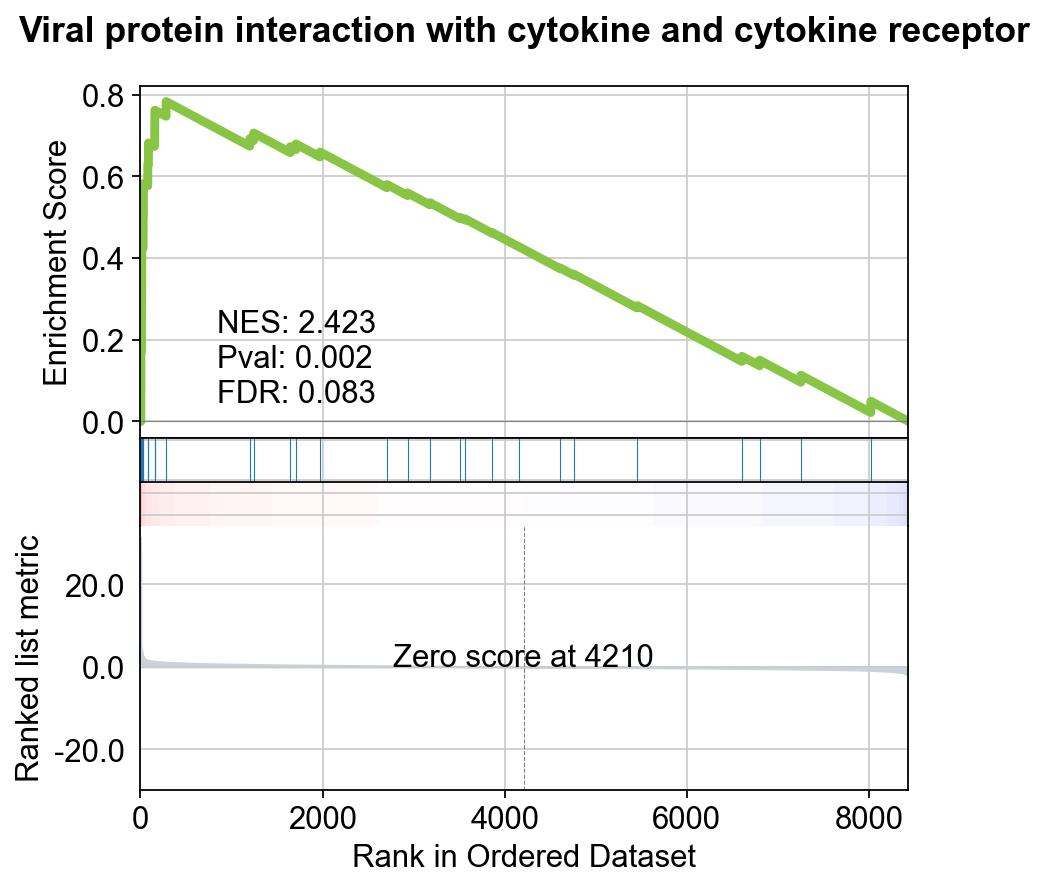

In [130]:
gseapy.gseaplot(rank_metric=res.ranking, term=terms[0], **res.results[terms[0]])

#DGE_ALL8:

#DGE_ALL10:

In [ ]:
adata.write_h5ad('./data/results/scanpy_DGE_covid.h5ad')